# Analyze NGA-West2 database

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bakerjw/shra-jupyter/blob/main/notebooks/04%20NGAW2%20Analysis.ipynb)

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Set up color and line style specifications

In [2]:
colors = {
    1: np.array([56, 95, 150])/255,
    2: np.array([207, 89, 33])/255,
    3: np.array([158, 184, 219])/255,
    4: np.array([231, 184, 0])/255,
    5: np.array([128, 0, 0])/255
}

## Load database flatfile

The original Excel file is from https://peer.berkeley.edu/research/databases/databases. It is easier to load from a CSV format. So the script checks for a CSV copy and uses that if possible. Otherwise it loads the original file and saves it as a CSV copy for future use.

In [3]:
# Define file paths
excel_path = '../data/Updated_NGA_West2_Flatfile_RotD50_d050_public_version.xlsx'
csv_path = '../data/nga_w2_flatfile.csv' 

# Check if the CSV file exists
if os.path.exists(csv_path):
    nga_w2_flatfile = pd.read_csv(csv_path)
else:
    print(f"CSV file not found. Loading data from Excel file: {excel_path}")
    nga_w2_flatfile = pd.read_excel(excel_path)
    
    # convert Object columns to strings
    object_columns = nga_w2_flatfile.select_dtypes(include=['object']).columns
    nga_w2_flatfile[object_columns] = nga_w2_flatfile[object_columns].astype('string')
    
    # Save to CSV for future use
    nga_w2_flatfile.to_csv(csv_path, index=False)   


x1 = nga_w2_flatfile.columns.get_loc("T0.010S")

/var/folders/3f/m11yz8gs3xl7p428csg_wb380000gr/T/ipykernel_81397/4192188532.py:7: DtypeWarning: Columns (2,29,43,45,54,86,91,93,94,95,96,97,105,118,266,269,270) have mixed types. Specify dtype option on import or set low_memory=False.
  nga_w2_flatfile = pd.read_csv(csv_path)


In [4]:
# extract response spectra

x1 = nga_w2_flatfile.columns.get_loc("T0.010S")
x2 = nga_w2_flatfile.columns.get_loc("T20.000S") + 1
response_spectra_df = nga_w2_flatfile.iloc[:, x1:x2]

## Make a scatter plot of magnitudes and distances

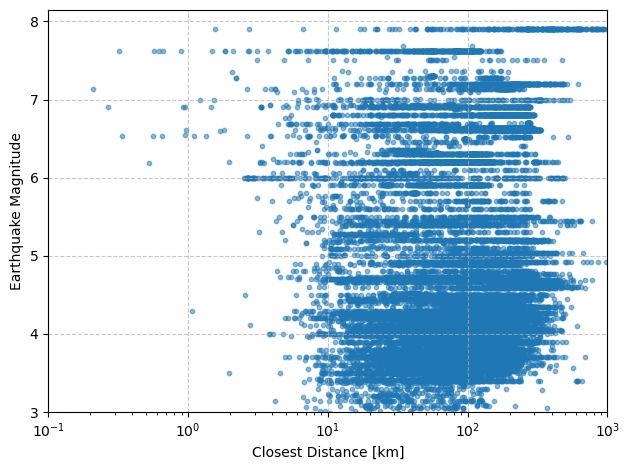

In [5]:
# omit -999 values
cleaned_data = nga_w2_flatfile[(nga_w2_flatfile['Earthquake Magnitude'] != -999) & (nga_w2_flatfile['ClstD (km)'] != -999)]


plt.figure()
plt.scatter(cleaned_data['ClstD (km)'], cleaned_data['Earthquake Magnitude'], alpha=0.5, s=10)
plt.xlabel('Closest Distance [km]')
plt.ylabel('Earthquake Magnitude')
plt.xscale('log')  
plt.xlim(left=0.1)  
plt.xlim(right=1000)  
plt.ylim(bottom=3)  
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Look at usable period range


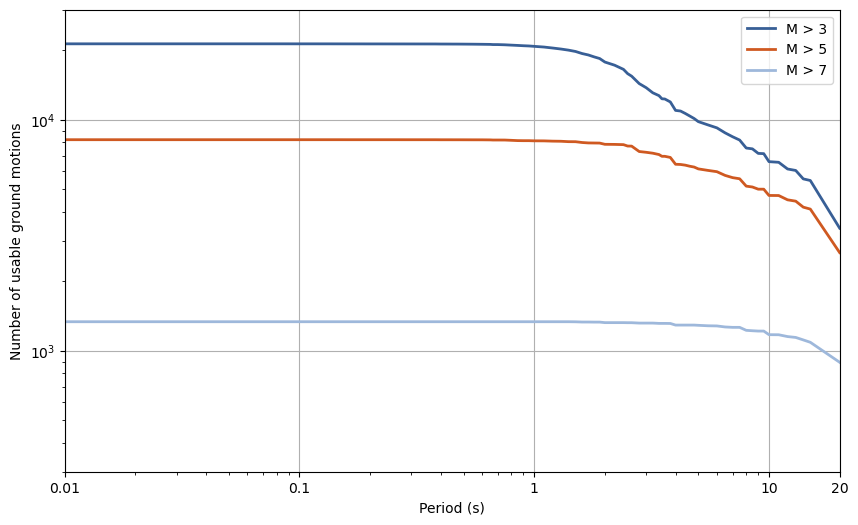

In [12]:
# Screen records
m_min_values = [3, 5, 7]
clst_d_max = 500

# Extract periods from response spectra column names
# The columns are named like "T0.010S", "T0.020S", etc.
period_columns = [col for col in response_spectra_df.columns if col.startswith('T') and col.endswith('S')]
periods = np.array([float(col[1:-1]) for col in period_columns])  # Extract numeric period values

# Maximum usable period
max_t = 1.0 / nga_w2_flatfile['Lowest Usable Freq - H1 (Hz)']

# Create the figure
plt.figure(figsize=(10, 6))

# Loop through each m_min value
for i, m_min in enumerate(m_min_values):
    count = np.where((nga_w2_flatfile['ClstD (km)'] < clst_d_max) & (nga_w2_flatfile['Earthquake Magnitude'] > m_min))[0]
    
    # Calculate usable period count
    usable_t_count = np.zeros(len(periods))
    for k in range(len(periods)):
        usable_t_count[k] = np.sum(max_t[count] > periods[k])
    
    # Plot with different colors and labels
    plt.loglog(periods, usable_t_count, color=colors[i+1], label=f'M > {m_min}', linewidth=2)

plt.xlabel('Period (s)')
plt.ylabel('Number of usable ground motions')
plt.axis([0.01, 20, 300, 30000])
plt.xticks([0.01, 0.1, 1, 10, 20], ['0.01', '0.1', '1', '10', '20'])
plt.grid(True)
plt.legend()
# plt.savefig('num_Usable_T.png', dpi=300)
plt.show()